# "emPPCA" examples

In this notebook, we demonstrate examples of `emPPCA` applied on various datasets. 

To load the module:

In [1]:
import sys
sys.path.append('../')
from replicatePPCA import emPPCA

There are other modules required in this notebook for pre-processing and visualizing:

In [2]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.patches as mpatches
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.impute import KNNImputer
from sklearn.metrics import mean_squared_error as MSE
from natsort import index_natsorted
from matplotlib.colors import Normalize

---

# 1 &nbsp; Tobomovirus dataset
Data for 38 distinct tobamoviruses with features including the number of amino acid residues per molecule of the coating protein, previously used on P.291 in [1]. The data is randomly added with varying degrees of noise to establish a replicated structure. One may see in the variance plot that indeed the unexplained variance follows the degree of perturbation.

Below we are doing some manipulation to formulate the target dataset into the required form to create the `emPPCA` instance. Specifically, the parameter `Y` of the instance should be a list of numpy array matrices, where each matrix represents a replicate. In such a matrix, each row represents an observation; Additionally each matrix should have the same number of columns (features), but can have potentially different number of rows (observations).

Notice that we have to standardize the data after the synthetic perturbation, in order to exlude the masked entires in standardization. `StandardScaler()` method will automatically ignore missing values in mean-centering and deviation-standardizing.

In [3]:
# Dataframe loading
virus = pd.read_csv('../datasets/tobomovirus/virus3.txt', delimiter='\s+', header=None).values

# Synthetic replicates of different perturbation
np.random.seed(123)
R = 4
name_rep = []
Y = []
perturb = []
scale = 3 / (R-1)
for r in range(R):
    perturb.append(np.random.normal(loc=0.0, scale=scale*r, size=virus.shape))
    current_rep = virus + perturb[r] # Add random perturbation
    mask = np.random.choice([True, False], size=virus.shape, p=[0.2, 0.8]) # Create mask for matrix entries
    current_rep = np.where(mask, np.nan, current_rep) # Set each entry missing at the probability of 20%
    Y.append(current_rep) # Append the current replicate to the list
    
# Concatenate replicates to standardise together
Y_concat = np.concatenate(Y)
scaler_nan = StandardScaler()
Y_concat = scaler_nan.fit_transform(Y_concat)

# Split replicates back to the required form
counter = 0
for r in range(R):
    Y[r] = Y_concat[counter:(counter+Y[r].shape[0]), :]
    counter += Y[r].shape[0]

## 1.1 &nbsp; Package usage
Below we create the `tobomovirus` instance, and fit the model. \
For simplicity, we only fit the first two principal components; And for replicability, we set the random seed `123`.

In [4]:
tobomovirus = emPPCA(Y=Y, q=2)
tobomovirus.fit(seed=123)

EM algorithm converged with 22 iterations; with relative change 8.415989203645561e-07.


We can plot log-likelihoods against iterations to inspect if the EM algorithm converges well. Users are able to specify a file name for the method to save the figure to local folders.

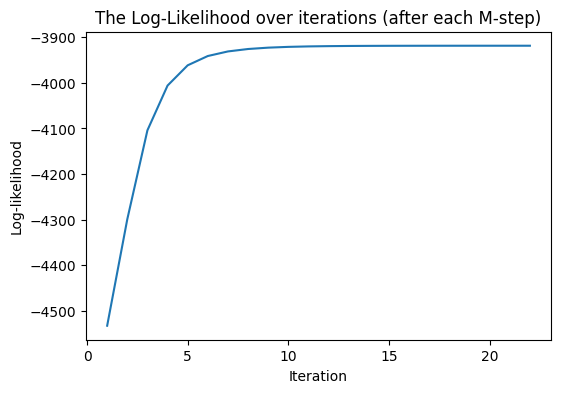

In [5]:
tobomovirus.likelihood_plot('tobomovirus_likelihood_plot') # Saved as file "tobomovirus_likelihood_plot"

An important aspect of the replicate-wise approach to PCA is that we are able to inspect the proportion of variance unexplained under the PPCA model. When the proportion is close to 1, it suggests that the PCA/PPCA model might not be well-posed for the corresponding replciate. Hence users might be willing to examine this replicate, to check for technical variations, etc.

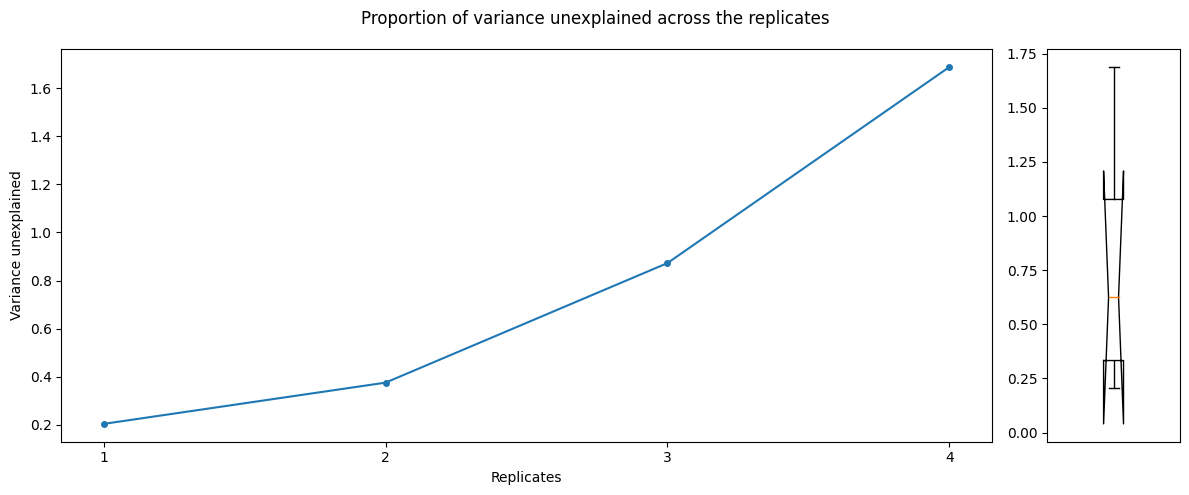

In [6]:
tobomovirus.variance_plot('tobomovirus_variance_plot') # Saved as file "tobomovirus_variance_plot"

We are able to visualize low dimensional representations in any combination of the replicates, as the examples given below.

The `X_plot` method uses different colors to compare either replicates or classes according to specification through `compare`. If the parameter is not specified, the method uses different marker shapes to distinguish different replicates, and different color for different classes.

Here we use `compare='replicate'`, which means that we are interested in distinguishing the replicates, and one marker shape represents a replicate. \
For clarity, when we are interested in distinguishing the replciates only, different colors are also used for different replicates. \
**NB:** When specifying the replicate, user should use numbers, which starts naturally from 1 to R. (instead of starting from 0)

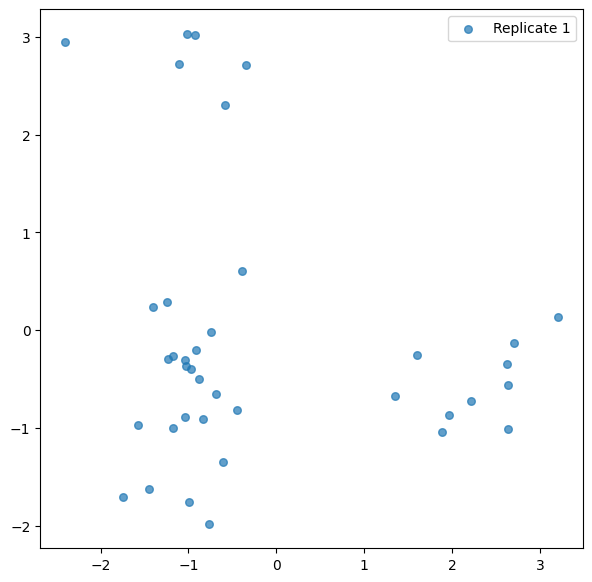

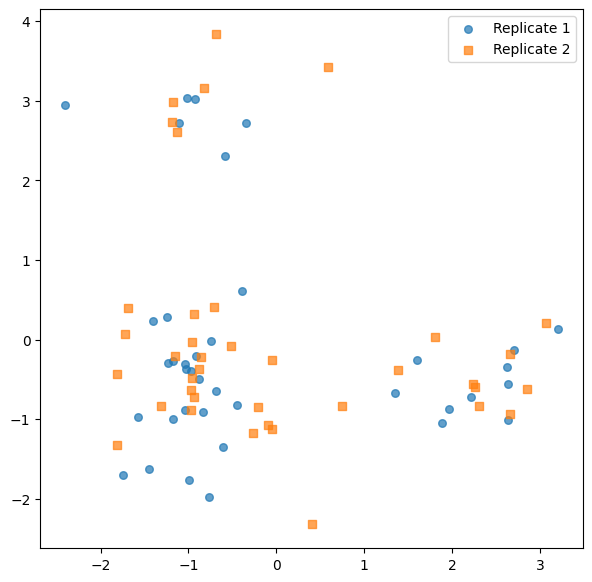

In [7]:
tobomovirus.X_plot(compare='replicate', reps=[1], name='tobomovirus_X_plot_1')
tobomovirus.X_plot(compare='replicate', reps=[1,2], name='tobomovirus_X_plot_2')

Alternatively, if class labels are specified when creating the instance, users can compare the classes under the low-dimensional representation. In this example, labels are unkonwn, hence using `compare='class'` will be a simple scattering of points.

## 1.2 &nbsp; Comparison with PCA

### 1.2.1 &nbsp; comparison on lower-dimensional maps (latent maps)
Below we compare the results from emPPCA and from PCA, with their abundance score visualized. 
- The first plot comes from `emPPCA`.
- The second plot comes from PCA, fitted to the concatenation of replicate-wise observations. We impute missing values via 3-Nearest Neighbors considering the size of dataset and convention.

The axes has been set to almost the same. One may see that `emPPCA` is giving a better separation.

The dataset has full observations, hence the abundance plot is not representative.


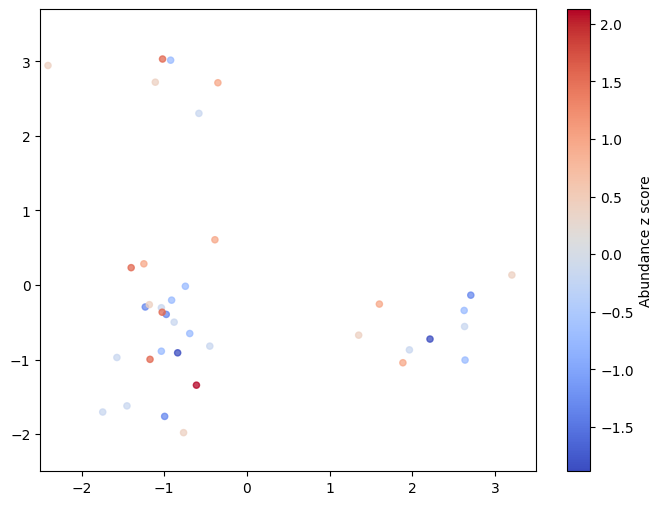

/var/folders/m1/8k0szlrx5rq2pb7921zgv55w0000gn/T/ipykernel_74021/976117458.py:20: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap='coolwarm'), label='Abundance z score');


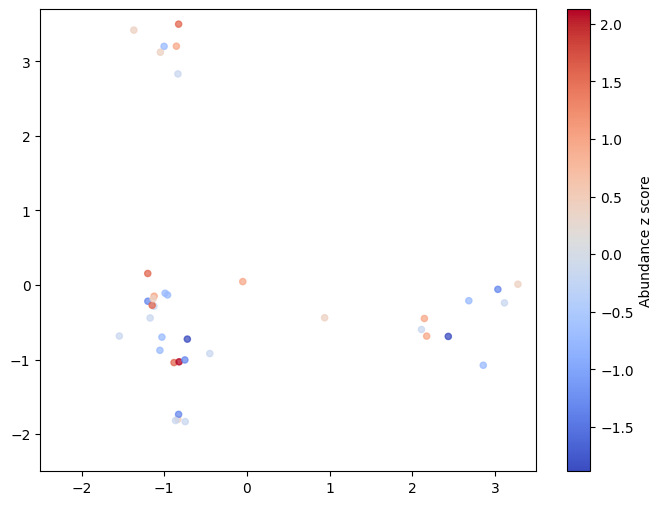

In [8]:
# The replicate we would like to compare
rep = 1

# emPPCA, with automatic imputation
tobomovirus.abundance_plot([rep], lims=[-2.5, 3.5, -2.5, 3.7])

# PCA, with K-NN imputation
Y_imputed = KNNImputer(n_neighbors=3).fit_transform(np.concatenate(Y))
scaler_pca = StandardScaler()
Y_imputed_std = scaler_pca.fit_transform(Y_imputed)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(Y_imputed_std)
# Plot with abundance z score
norm = Normalize(vmin=min(tobomovirus.z_score[rep-1]), vmax=max(tobomovirus.z_score[rep-1]))
colors = plt.cm.coolwarm(norm(tobomovirus.z_score[rep-1]))
plt.figure(figsize=(8, 6))
plt.xlim([-2.5, 3.5])
plt.ylim([-2.5, 3.7])
plt.scatter(X_pca[38*(rep-1):38*rep, 0], X_pca[38*(rep-1):38*rep, 1], c=colors, alpha=0.75, s=20)
plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap='coolwarm'), label='Abundance z score');

### 1.2.2 &nbsp; Comparison on reconstruction
Below is a comparison of the reconstruction mean squared error (MSE) via the standard PCA method and emPPCA method. \
Different values of $K$ in the $K$-NN imputation for PCA has been tested. The results are shown via a plot of change in MSE as we alter $K$. \
The horizontal line represents the reconstruction MSE under emPPCA method.

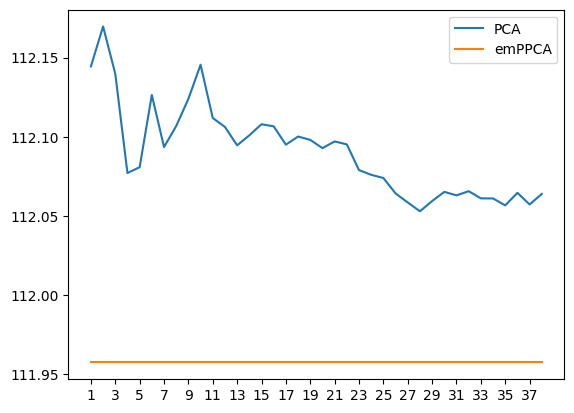

In [9]:
# Computation of MSEs
MSE_emppca = MSE(np.vstack([virus]*R), np.concatenate(tobomovirus.recon))
MSE_pca = [0 for k in range(38)]   
for k in range(38):
    # Fit k-NN imputed PCA transformations
    Y_imputed = KNNImputer(n_neighbors=k+1).fit_transform(np.concatenate(Y))
    scaler_pca = StandardScaler()
    Y_imputed_std = scaler_pca.fit_transform(Y_imputed)
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(Y_imputed_std)
    recon = pca.inverse_transform(X_pca)
    recon = scaler_pca.inverse_transform(recon)
    MSE_pca[k] = MSE(np.vstack([virus]*R), recon)
# Plot comparison of MSEs
plt.plot(np.arange(38)+1, MSE_pca, label='PCA')
plt.plot(np.arange(38)+1, [MSE_emppca]*38, label='emPPCA')
plt.xticks(2*np.arange(19)+1)
plt.legend();

We compare the visualization of the reconstruction here. The lower-dimensional representations are being mapped to the original scale of the data. Since the data has $18$ features, making it hard for a complete visualization, we consider particularly the sets of features with the largest variance and the least variance. We only compare the first replicate from both methods, with the original data without perturbation.

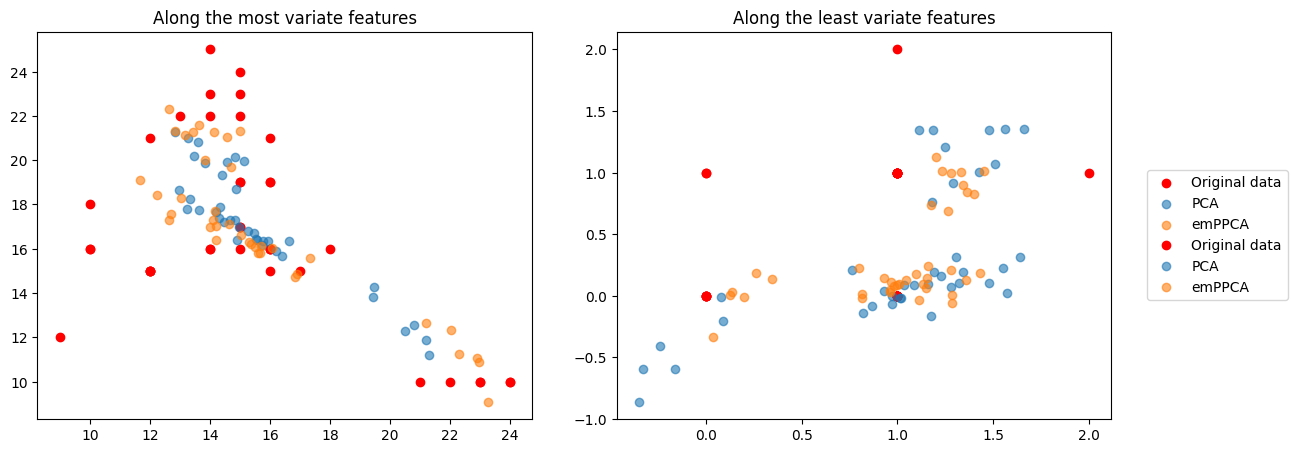

In [10]:
# Compare replicate 1 here
r = 1
# Perform PCA with 28-NN imputation, and get its reconstruction
Y_imputed = KNNImputer(n_neighbors=k+1).fit_transform(np.concatenate(Y))
scaler_pca = StandardScaler()
Y_imputed_std = scaler_pca.fit_transform(Y_imputed)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(Y_imputed_std)
recon_pca = pca.inverse_transform(X_pca)
recon_pca = scaler_pca.inverse_transform(recon_pca)
recon_pca = scaler_nan.inverse_transform(recon_pca)
# Reconstruction of emPPCA
recon_emppca = scaler_nan.inverse_transform(tobomovirus.recon[r-1])

# Along the most variate features
fig, ax = plt.subplots(1,2, figsize=(12,5))
plt.tight_layout(pad=3)
x, y = np.argsort(np.std(virus, axis=0))[-2:] # The features of maximum variance
ax[0].scatter(virus[:, x], virus[:, y], label='Original data', c='r')
ax[0].scatter(recon_pca[38*(r-1):38*r, x], recon_pca[38*(r-1):38*r, y], label='PCA', alpha=0.6)
ax[0].scatter(recon_emppca[:,x], recon_emppca[:,y], label='emPPCA', alpha=0.6)
ax[0].set_title('Along the most variate features')

# Along the least variate features
x, y = np.argsort(np.std(virus, axis=0))[:2] # The features of maximum variance
ax[1].scatter(virus[:, x], virus[:, y], label='Original data', c='r')
ax[1].scatter(recon_pca[38*(r-1):38*r, x], recon_pca[38*(r-1):38*r, y], label='PCA', alpha=0.6)
ax[1].scatter(recon_emppca[:,x], recon_emppca[:,y], label='emPPCA', alpha=0.6)
ax[1].set_title('Along the least variate features')

# Make the legend
fig.legend(loc='center left', bbox_to_anchor=(0.98, 0.5));

---

# 2 &nbsp; pSCoPE Fig.4a

Mass-spectrometry proteomics data under pSCoPE, comparing the bone marrow-derived macrophages (BMDM) that are treated or untreated with lipopolysaccharide (LPS) [2]. The experiments were executed in 40 batches; hence we broadly assume these to represent 40 replicates.

As the processed dataset has already imputed the missing entries, we seek for the raw dataset. For proteins with multiple records, the mean is taken. For an observation and a particular protein, if the data is across all records, we consider that entry to be missing. Code chunk below does this task.

In [11]:
data = pd.read_csv('../datasets/pSCoPE/limmaCorrected_normed_prePCA_Priori_mrri02_PIF50_DART_1pFDR.csv', index_col=0).T
data

,A1L314,A2ADY9,B2RXS4,B2RY56,B9EJ86,C0HKE1,D0QMC3,D3YXK2,D3Z6Q9,D3Z7P3,...,Q9Z1X4,Q9Z204,Q9Z2I8,Q9Z2I9,Q9Z2L7,Q9Z2U0,Q9Z2U1,Q9Z2W0,Q9Z2X1,Q9Z315
i10,-0.713556,0.145136,-0.354598,-0.762069,0.415763,-0.162348,-0.221980,0.678699,0.665889,0.789450,...,0.386162,0.137461,-0.161221,0.151998,-0.115415,0.259164,0.099600,0.333715,-1.035868,0.183049
i102,0.115632,-0.198168,-0.068785,0.293376,-0.046524,0.285246,0.252466,-0.187978,-0.386807,0.067947,...,-0.400537,-0.238384,0.217086,0.118207,0.139070,-0.214693,0.034489,0.235256,-0.377464,-0.101458
i103,-0.000121,0.153455,-0.126309,-0.244789,-0.195224,0.115452,0.212296,0.047892,-0.342417,-0.468670,...,-0.466717,-0.239643,0.208821,-0.141121,-0.002796,0.574646,-0.279009,0.117101,-1.498220,0.328699
i104,0.185122,0.337143,-0.114429,0.116092,0.227646,-0.157437,-0.295495,0.192285,-0.264709,-0.029815,...,-0.697855,-0.158024,0.289547,0.108620,-1.037004,-0.054307,0.565347,0.422122,-0.096001,0.415248
i105,-0.509164,-0.020522,-1.006876,-0.108895,0.467114,-0.156859,-0.480461,-0.311154,0.179026,-0.411642,...,0.562486,0.019632,-0.221525,-0.003691,-0.247040,0.199040,-0.225015,0.318524,0.369355,-0.110945
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
i91,-0.106351,0.404225,-0.401132,-0.546342,-0.249355,-0.655943,0.093453,-0.078778,0.284190,0.216590,...,-0.238973,0.004873,0.155651,0.021479,-0.034972,0.111978,-0.071247,-0.442385,-0.082636,-0.864145
i92,-0.077350,0.546720,-0.033853,-1.874456,-0.191049,-0.546356,-0.079562,-0.013503,-0.713329,-0.391080,...,0.164151,-0.022888,0.129448,0.390637,-1.011721,-0.134907,-0.519659,-0.819834,-0.802566,-0.320224
i93,0.076147,-0.102604,0.057099,0.369373,-0.118931,0.141373,0.417487,0.059770,0.599307,-0.532418,...,0.562696,0.125735,0.016066,-0.187995,-0.151031,-0.030501,0.279676,0.487763,0.543985,-0.365112
i94,0.031788,0.173423,-0.002282,0.188923,-0.416988,-0.252630,-0.575777,-0.055236,-0.882281,-0.045458,...,0.068790,-0.097286,-0.402669,-0.009771,0.154916,-0.105891,-0.327711,0.380336,0.424987,0.335892


The following chunk is a replication of Figure 4a of the pSCoPE paper in Python (originally in R):

In [12]:
def pSCoPE_replicate_plot(prePCA, CG, bulkBC):
    # Filter common proteins
    common_proteins = prePCA.index.intersection(bulkBC.index)
    prePCA = prePCA.loc[common_proteins,:]
    bulkBC = bulkBC.loc[common_proteins,:]

    # Perform PCA
    # prePCA = pd.DataFrame(StandardScaler().fit_transform(prePCA.T), index=prePCA.columns, columns=prePCA.index).T
    pca = PCA(n_components=2)
    PCAout = pca.fit_transform(prePCA.T)
    PCAout = pd.DataFrame(pca.fit_transform(prePCA.T), columns=['PC1', 'PC2'], index=prePCA.columns)
    PCAout.reset_index(inplace=True)
    PCAout.rename(columns={'index': 'id'}, inplace=True)
    PCAout = PCAout.merge(CG, on='id', how='left')

    # Apply fitted PCA to bulk data
    bulkBC_imp_mat = bulkBC[['i700', 'i701']].copy()
    bulk_coord = pca.transform(bulkBC_imp_mat.T)
    bulk_coord = pd.DataFrame(bulk_coord, columns=['PC1', 'PC2'], index=['i700', 'i701'])
    bulk_coord.reset_index(inplace=True)
    bulk_coord.rename(columns={'index': 'id'}, inplace=True)
    bulk_coord['celltype'] = ["LPS", "untreated"]

    # Plot figure
    fig, ax = plt.subplots(figsize=(7,7))
    full_coord = pd.concat([PCAout, bulk_coord], ignore_index=True)
    full_coord['Source'] = np.where(full_coord['Raw.file'].isna(), 'Bulk', 'Single cell')
    colors = {'LPS':'#F8766D', 'untreated':'#00BFC4'}
    # Single cell scatter
    for ctype in full_coord['celltype'].unique():
        condition = (full_coord['Source'] == 'Single cell') & (full_coord['celltype'] == ctype)
        ax.scatter(full_coord.loc[condition, 'PC1'], full_coord.loc[condition, 'PC2'],
                   color=colors.get(ctype), marker='o', alpha=0.7)
    # Bulk scatter
    for ctype in full_coord['celltype'].unique():
        condition = (full_coord['Source'] == 'Bulk') & (full_coord['celltype'] == ctype)
        ax.scatter(full_coord.loc[condition, 'PC1'], full_coord.loc[condition, 'PC2'],
                   color=colors.get(ctype), marker='s', facecolors='none', linewidths=3, s=1000, alpha=0.7)
    # Figure settings
    legend_labels = [mpatches.Patch(color='#F8766D', label='LPS'), 
                     mpatches.Patch(color='#00BFC4', label='untreated'), 
                     plt.Line2D([0], [0], color='gray', marker='s', markerfacecolor='none', linestyle='', label='Bulk'),
                     plt.Line2D([0], [0], color='gray', marker='o', linestyle='', label='Single cell')]
    ax.legend(handles=legend_labels)
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    plt.show()

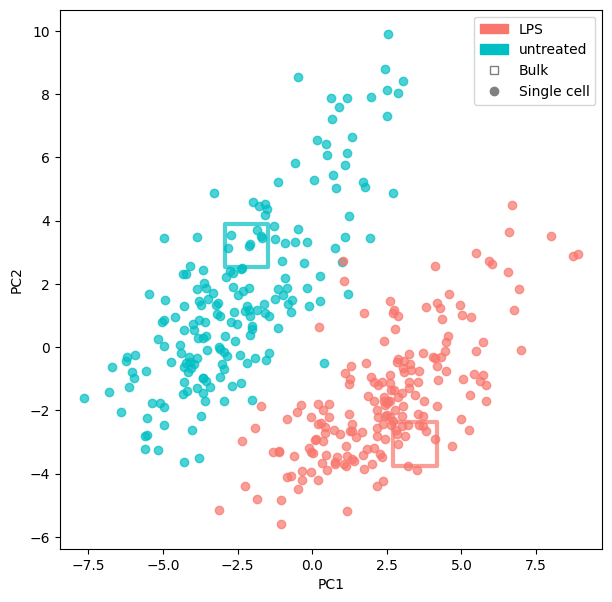

In [13]:
prePCA = pd.read_csv('../datasets/pSCoPE/limmaCorrected_normed_prePCA_Priori_mrri02_PIF50_DART_1pFDR.csv', index_col=0)
CG = pd.read_csv('../datasets/pSCoPE/ChanKey_BMDM_Priori_mrri02_PIF50_DART_FDR1p.txt', sep='\t')
bulkBC = pd.read_csv('../datasets/pSCoPE/imputed_BC_BMDM_priori_mrri02_PIF50_DART1pFDR_withBulk.txt', sep='\t')
pSCoPE_replicate_plot(prePCA, CG, bulkBC)

We now consider masking some entries synthetically, and uses mean imputation and feed into the original plotting method above:

In [14]:
# Masking entries
np.random.seed(123)
mask = np.random.choice([True, False], size=prePCA.shape, p=[0.4, 0.6])
prePCA_mask = pd.DataFrame(np.where(mask, np.nan, prePCA), index=prePCA.index, columns=prePCA.columns)

We could now comapre the PCA results produced either by PCA with mean-imputation, or emPPCA for replicates.

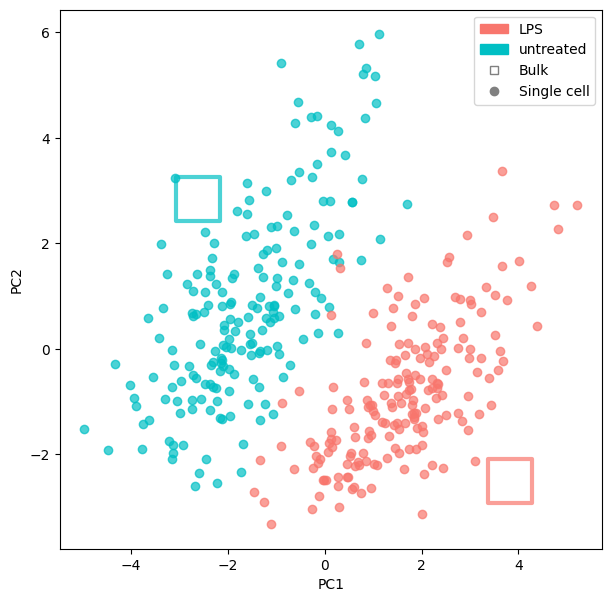

EM algorithm converged with 227 iterations; with relative change 9.799819236909562e-07.


/Users/jerry/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


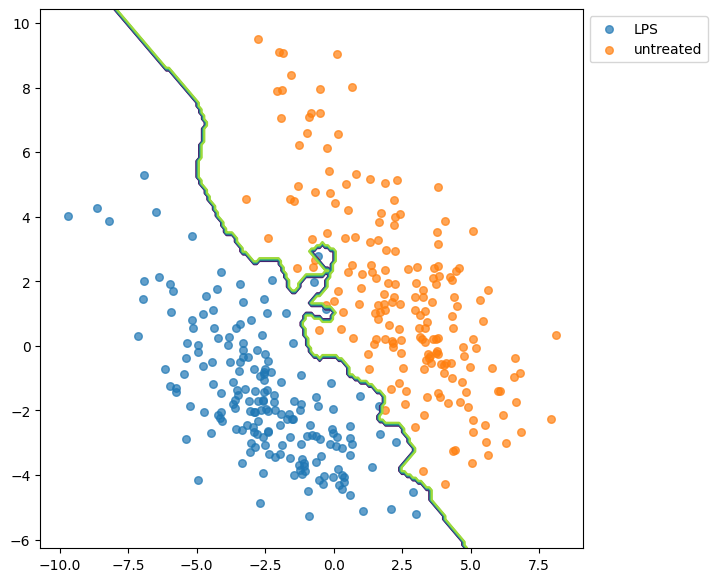

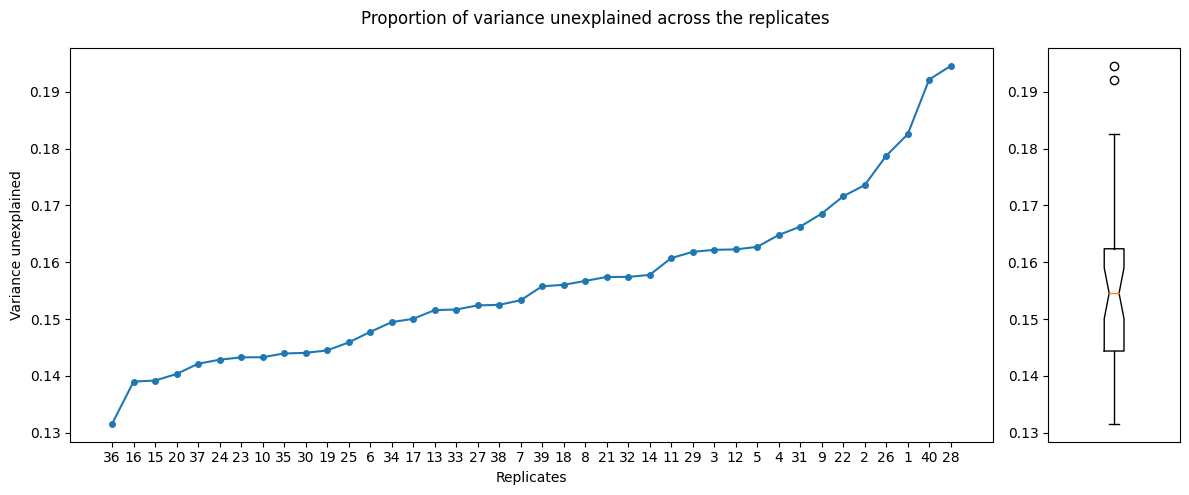

In [15]:
# Original method
prePCA_impute = prePCA_mask.fillna(prePCA_mask.mean()) # Fill NaN with feature means
pSCoPE_replicate_plot(prePCA_impute, CG, bulkBC)

# emPPCA method
data = prePCA_mask.T
data['id'] = data.index
data = data.merge(CG, on='id', how='left')
id_rep = [] 
label_rep = [] 
Y = [] 
R = 40 
for r in range(R):
    label_rep.append(data[data['Raw.file'] == f'XwGH05{r:02d}']['celltype'])
    Y.append(data[data['Raw.file'] == f'XwGH05{r:02d}'].iloc[:, :-5].values)  
# emPPCA
pSCoPE = emPPCA(Y=Y, q=2, label=label_rep)
pSCoPE.fit()
pSCoPE.X_plot(compare='class', NN=True, name='pSCoPE_compare', separate_legend=True)
pSCoPE.variance_plot()

By inspecting the above plot, people may find replicates 28 and 40 have particularly high variance unexplained. So it might be necessary for researchers to have a check for the experiments related to these replicates. Below we first use colors to explicitly distinguishing these two replicates, then we compare these two replicates with the replicate with the lowest variance unexplained.

After identifying some potential explanation for this, one may consider to exclude these replicates from the usage of PCA/PPCA; Because these observations are relatively not explained well by the model, and thus the low-dimensional representations may give information more different from the full feature observations.



/Users/jerry/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


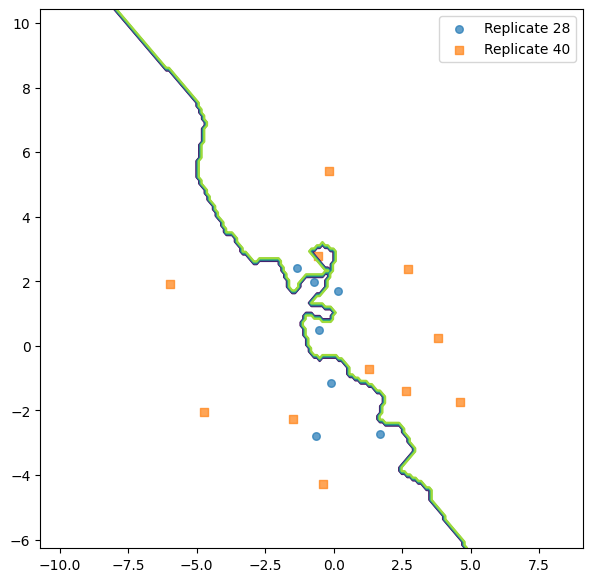

/Users/jerry/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


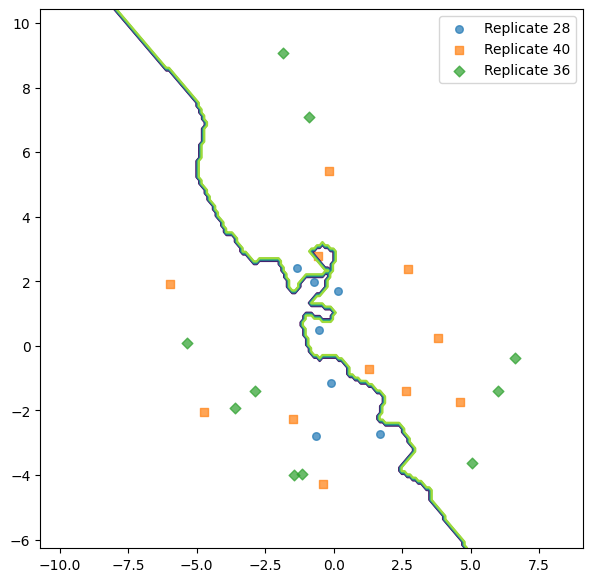

In [24]:
pSCoPE.X_plot(compare='replicate', NN=True, reps=[28,40], name='pSCoPE_X_plot_1')
pSCoPE.X_plot(compare='replicate', reps=[28,40,36], NN=True, name='pSCoPE_X_plot_3')

Say, after investigation these replicates have been suffered by high variances due to some reason, and the researchers have decided to drop them for the visualization purpose; Then the following visualization gives a less wiggly 1-NN line, and hence a better separation.

EM algorithm converged with 240 iterations; with relative change 9.970658397100476e-07.


/Users/jerry/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


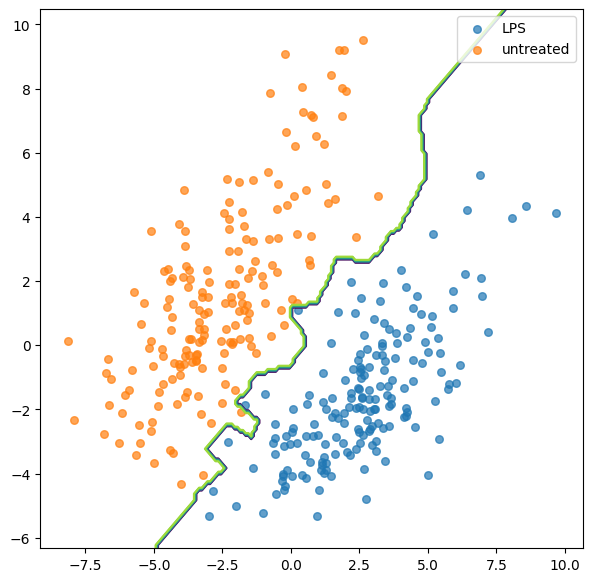

In [17]:
Y_reduced = [item for idx, item in enumerate(Y) if idx not in {27,39}]
label_rep_reduced = [item for idx, item in enumerate(label_rep) if idx not in {27,39}]
pSCoPE_reduced = emPPCA(Y_reduced, 2, label_rep_reduced)
pSCoPE_reduced.fit()
pSCoPE_reduced.X_plot(compare='class', name='pSCoPE_reduced')

Finally, we give the abundance plot of the above synthetically masked dataset.

The dataset has full observations, hence the abundance plot is not representative.


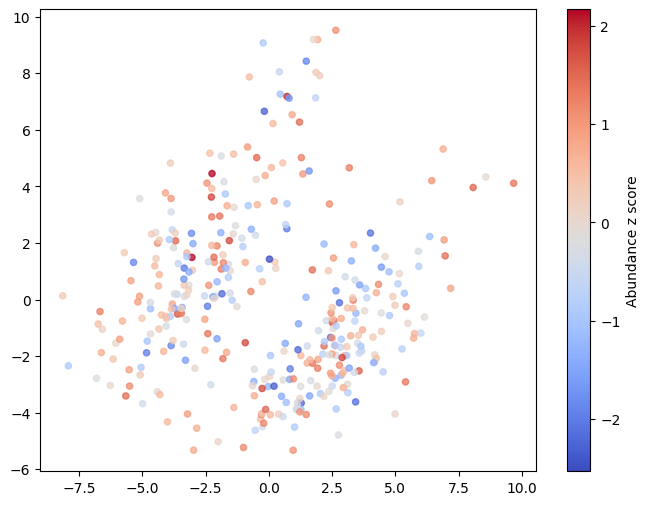

In [18]:
pSCoPE_reduced.abundance_plot()

---
### plexDIA Fig.6p

Mass-spectrometry proteomics data under plexDIA, comparing Melanoma, pancreatic ductal adenocarcinoma (PDAC), and monocyte (U-937) [3]. Two different mass spectrometer were used for data acquisition, namely 'Q-Exactive' and 'timsTOFSCP', which can be considered naturally as a pair of replicates. The dataset (or the original figure) also includes markers for bulk data. We will not include them as a replicate here.
Thus two replicates and their observation id in the guidence file are:
1. 'QE', id1-id144
2. 'timsTOFSCP', id157-id186

In [19]:
R = 2

# Dataframe loading (164 observations in total)
data = pd.read_csv('../datasets/plexDIA/Proteins_SC_IDs.txt', sep='\s+')
data = data.drop(columns=['prot']).T
data = data.iloc[index_natsorted(data.index)]
data = pd.DataFrame(StandardScaler().fit_transform(data), columns=data.columns, index=data.index)
# Guidance file
guide = pd.read_csv('../datasets/plexDIA/Meta_SC.tsv', sep='\s+', index_col=0)
guide = guide.set_index('id')
guide = guide.iloc[index_natsorted(guide.index)]
guide = guide[guide.index.isin(data.index)]

# Replicate 1
QE_id = list(guide[(guide['Instrument']=='Q-Exactive') & (guide['Real_single_cell']==True)].index)
# Replicate 2
timsTOFSCP_id = list(guide[(guide['Instrument']=='timsTOFSCP') & (guide['Real_single_cell']==True)].index)

# Text labels
textlabel = [list(guide.loc[QE_id]['Celltype'])]
textlabel.append([i.replace('_t','') for i in list(guide.loc[timsTOFSCP_id]['Celltype'])])

# Formated list Y
Y = [data.loc[QE_id].values, data.loc[timsTOFSCP_id].values]

In [20]:
# Create model instance
plexDIA = emPPCA(Y, q=2, label=textlabel)
plexDIA.fit(max_iter=2000)

EM algorithm converged with 1045 iterations; with relative change 9.992883596059823e-07.


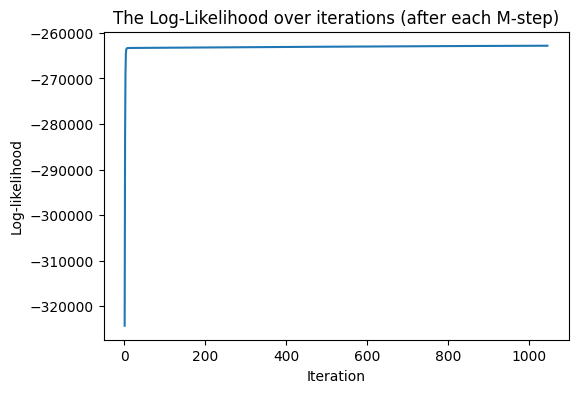

In [21]:
plexDIA.likelihood_plot(name='plexDIA_likelihood_plot')

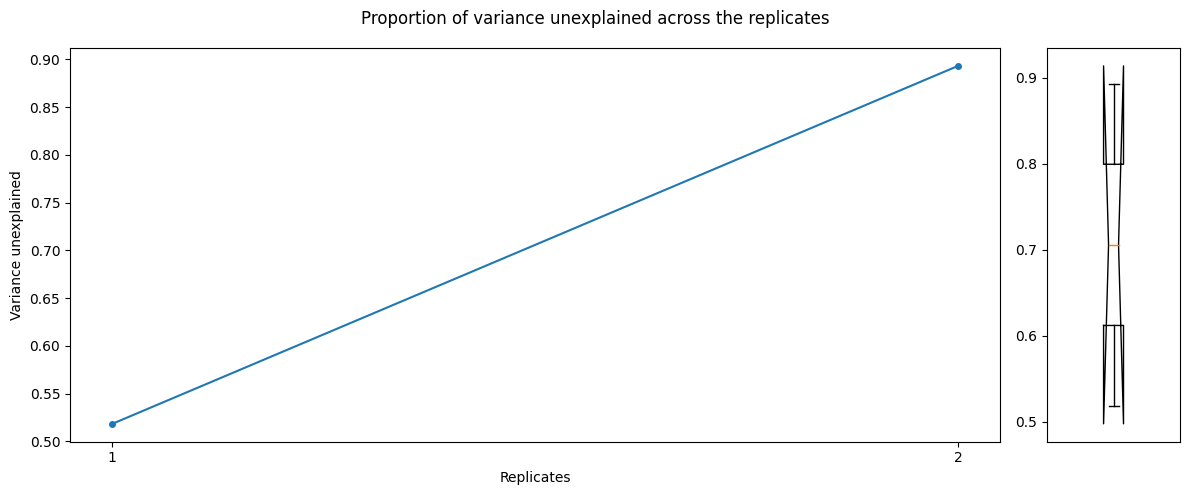

In [22]:
plexDIA.variance_plot(name='plexDIA_variance_plot')

Below we compare low-dimensional mappings from emPPCA with the mappings from vanilla PCA. We found that there is a pulled effect to the nearest point to 'U-937' from 'Melanoma'. \

Besides, the unexplained variance plot corresponds with the latent representations below: points from 'Replicate 2' are tend to be less separated compared to those from 'Replicate 1'.

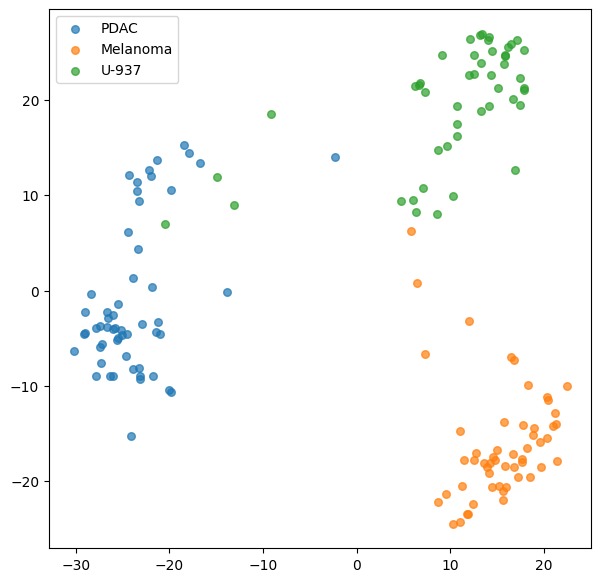

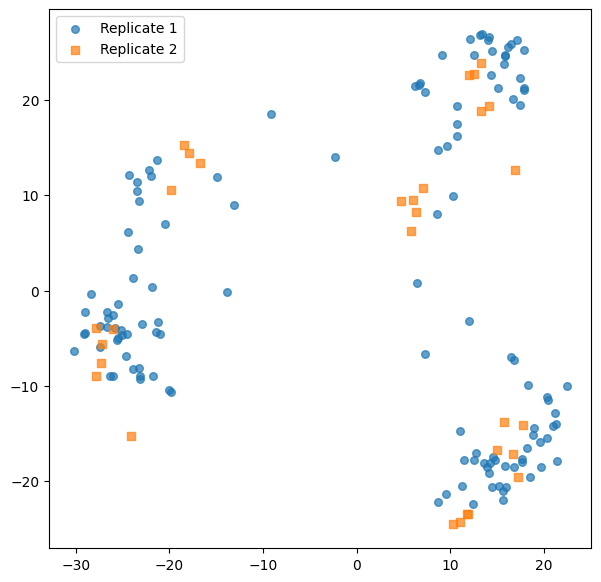

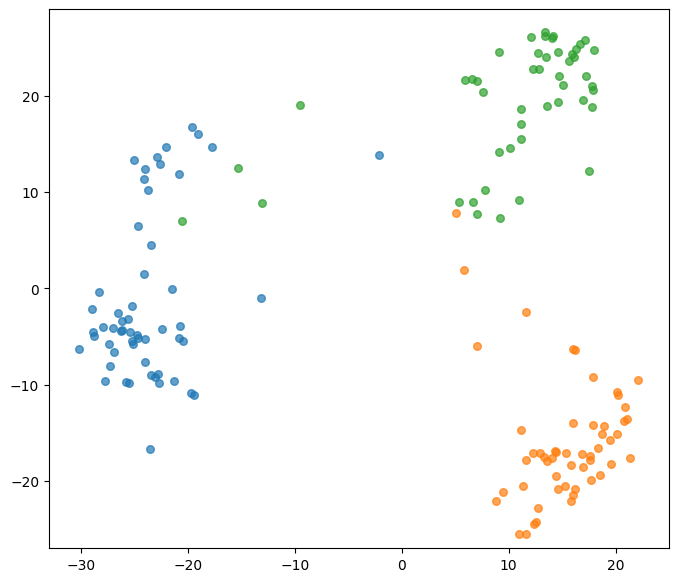

In [25]:
# emPPCA
plexDIA.X_plot(compare='class', NN=False, name='plexDIA_X_plot_1')
plexDIA.X_plot(compare='replicate', NN=False, name='plexDIA_X_plot_2')

# PCA
# Y_concat = np.concatenate(plexDIA.Y)
# PCA_X = PCA(n_components=2).fit_transform(Y_concat)
# plt.figure(figsize=(8,7))
# plt.xlim([-33,25])
# plt.ylim([-27,29])
# colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
# for i in range(len(plexDIA.text_classes)):
#     idx = np.where(np.concatenate(plexDIA.numberlabel) == i)[0]
#     plt.scatter(-PCA_X[idx,0], PCA_X[idx,1], alpha=0.7, s=30, c=colors[i]);

---

### References

###### [1] &nbsp; Ripley, B. D. (2007). Pattern recognition and neural networks. Cambridge university press.

###### [2] &nbsp; Huffman, R. G., Leduc, A., Wichmann, C., Di Gioia, M., Borriello, F., Specht, H., ... & Slavov, N. (2023). Prioritized mass spectrometry increases the depth, sensitivity and data completeness of single-cell proteomics. Nature methods, 20(5), 714-722.

###### [3] &nbsp; Derks, J., Leduc, A., Wallmann, G., Huffman, R. G., Willetts, M., Khan, S., ... & Slavov, N. (2023). Increasing the throughput of sensitive proteomics by plexDIA. Nature biotechnology, 41(1), 50-59.